In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as md
import read_flac_file as rff
from IPython.display import clear_output
from time import sleep
import time
import datetime as dt
from datetime import timedelta



def plot2signals(dir_flacs, fn_flac, time1, time2, normalized=False, yscale=8, wattage_data=''):
    """
    Samples two current cycles from different timestamps and prints them together for comparison.
    
    dir_flacs, fn_flac: directory and file name
    time1: start time for the initial cycle in seconds, plotted in blue
    time2: start time for the current cycle in seconds, plotted in red
    yscale: zooms in or out vertically
    wattage_data: optional, includes a wattage in the title
    normalized: very optional, scales the two signals
    
    """
    time_stamp = float(fn_flac[3:13])+float(fn_flac[14:20])/1e6
    time_frame = datetime.utcfromtimestamp(time_stamp).strftime('%Y-%m-%d %H:%M:%S and %f microseconds')
    
    # set the signal start and length in seconds
    signal_start = time1
    signal_start2 = time2 
    signal_length =0.1

    # read the voltage and current from the flac file
    (voltage,signal) = rff.read_flac_segment(dir_flacs + "/" + fn_flac, signal_start, signal_length)
    (voltage2,signal2) = rff.read_flac_segment(dir_flacs + "/" + fn_flac, signal_start2, signal_length)

    # find zero up-crossing indexes using a snippet adapted from SO suggestion
    zci = np.where(np.diff(np.sign(voltage))>0)[0]
    zci2 = np.where(np.diff(np.sign(voltage2))>0)[0]
    cycle_size = zci[1] - zci[0]
    
    # exit if the length of the second cycle is too different from the length of the initial cycle
    if abs(cycle_size-zci2[1]+zci2[0]) > 10 :
        return -1
    
    # plot the chosen two signals
    plt.style.use('seaborn-whitegrid')
    plt.figure(figsize = [12.8, 4.6])  
    plt.ylim(-yscale, yscale)
    plt.xlim(zci[0], zci[1])
    strtext = "Starting time of flac:{}\n{}:{}".format(time_frame, time2//60, time2%60) + wattage_data
    plt.title(strtext)
    sample_size = len(signal)
    x = np.linspace(0, sample_size, sample_size)
    
    # use this for the second signal so the zci points overlap
    x_translate = x - zci2[0] + zci[0]
    
    # truncates the signals
    s1 = signal[zci[0]:zci[0]+cycle_size]
    s2 = signal2[zci2[0]:zci2[0]+cycle_size]
    
    if normalized:
        s1 = 2.2*s1/np.max(s1)
        s2 = 2.2*s2/np.max(s2)
        
    # plots    
    plt.plot(x[zci[0]:zci[1]],s1,'b')
    plt.plot(x_translate[zci2[0]:zci2[0]+cycle_size],s2,'r')
    
def read_appliance(fnstem_slow_data, channel, hour):
    fn_dat = fnstem_slow_data + str(channel) + ".dat"

    # set time interval - the dat file covers a long period
    ts_day = time.mktime(dt.date(2016,1,4).timetuple())
    ts_hour = ts_day + hour*3600
    ts_next_hour = ts_hour + 3600 

    # read appliance (also called disaggregated) data
    df = pd.read_csv(fn_dat,' ') 
    df.columns = ['ts','watts']
    df = df.loc[(df['ts']>=ts_hour) & (df['ts']<ts_next_hour),:]    
    return df
    



Plot2 signals example. Blue is a cycle sampled from 0 seconds in, red is from 3000 seconds in.

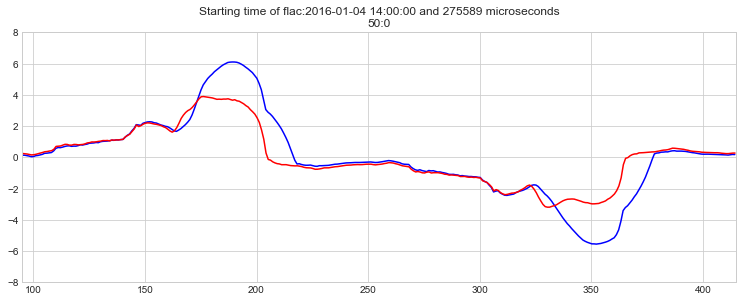

In [3]:
# location of the high frequency (audio) data
dir_flacs = 'D:/flep/ukdale/'
# location of low freqency data
fnstem_slow_data = "D:/flep/ukdale/house_1/channel_"
# name of flac file
fn_flac = 'vi-1451916000_275589.flac'
plot2signals(dir_flacs, fn_flac, 0, 3000, yscale=8)

The next sheet loops over the dataframe for a channel and uses plot2signals at each timestamp. Red is current cycle. Bule is initial cycle.

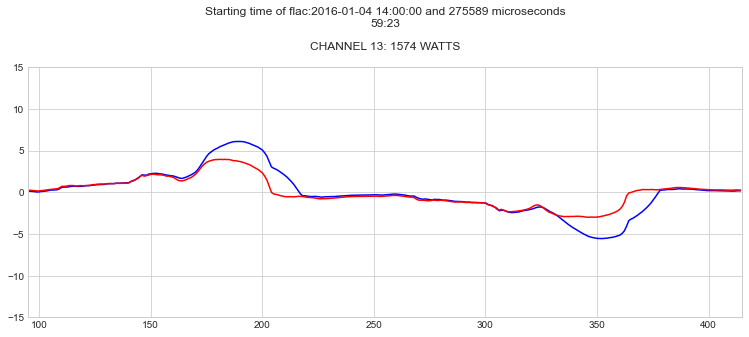

In [4]:
# flac file and using it to compute the hour
fn_flac = 'vi-1451916000_275589.flac'

time_stamp = float(fn_flac[3:13])+float(fn_flac[14:20])/1e6
hour = datetime.utcfromtimestamp(time_stamp).hour

#load an appliance dataframe
channel = 13

print('Reading channel %d data'%channel, hour)
df = read_appliance(fnstem_slow_data, channel, hour) 

df = df[:-5]

#loop through df and plot
for idx in df.index:
    ts = df['ts'][idx]
    watt = df['watts'][idx]
    date = dt.datetime.fromtimestamp(ts)
    
    plot2signals(dir_flacs, fn_flac, time1=0, time2=date.second + 60*date.minute, yscale=15, 
                 wattage_data="\n\nCHANNEL {}: {} WATTS\n".format(channel,watt))
    
    plt.show()
    
    sleep(0.01)
    clear_output(wait=True)